# GAN for ECG Data Augmentation
This notebook explores the use of Generative Adversarial Networks (GANs) to generate synthetic ECG signals for data augmentation.
Due to the class imbalance in the dataset, GANs are employed to create additional samples for underrepresented classes.

## Data Preprocessing

In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [24]:
# Load the dataset
df_train = pd.read_csv("../Data/mitbih_train.csv", header=None)
df_test = pd.read_csv("../Data/mitbih_test.csv", header=None)

In [25]:
# Check the Dimension of the Set
print(f"Training dataset shape: {df_train.shape} (rows, columns)")

print(f"Test dataset shape: {df_test.shape} (rows, columns)")


Training dataset shape: (87554, 188) (rows, columns)
Test dataset shape: (21892, 188) (rows, columns)


In [26]:
print("Label distribution in Training Set:")
print(df_train.iloc[:, -1].value_counts())

print("\nLabel distribution in Test Set:")
print(df_test.iloc[:, -1].value_counts())


Label distribution in Training Set:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Label distribution in Test Set:
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


## Seperate Train, test and hold-out set

In [5]:
import sys

# Add the 'src' directory to the Python path so we can import custom utility functions
sys.path.append("../src")  

# Import the stratified sampling function from utils.py
from utils import stratified_sample  

# Perform stratified sampling: extracting 3% of df_train as the validation set
df_validation, df_train = stratified_sample(df_train, 3)

# Split the remaining data into features (X) and labels (y) for training
X_train = df_train.iloc[:, :-1]  # Select all columns except the last one as features
y_train = df_train.iloc[:, -1]   # Select the last column as labels

# Split the validation data into features (X) and labels (y)
X_validation = df_validation.iloc[:, :-1]  # Features for validation set
y_validation = df_validation.iloc[:, -1]   # Labels for validation set

# Split the test data into two subsets: test set and holdout set (50% each)
# The holdout set will be used to evaluate robustness under noise and time shifts
from sklearn.model_selection import train_test_split

X_test, X_holdout, y_test, y_holdout = train_test_split(
    df_test.iloc[:, :-1],  # Features from test set
    df_test.iloc[:, -1],   # Labels from test set
    test_size=0.5,         # 50% of test data goes into the holdout set
    random_state=42        # Ensure reproducibility
)


In [6]:
# Print the class distribution in the validation set
# This helps verify that stratified sampling preserved the class balance
print(y_validation.value_counts())

# Print the class distribution in the training set
# Ensures we have a clear understanding of how many samples exist for each class
print(y_train.value_counts())


187
0.0    525
3.0    525
2.0    525
4.0    525
1.0    525
Name: count, dtype: int64
187
0.0    69846
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [7]:
# Identify the distribution of classes in the training set
class_distribution = y_train.value_counts().sort_values()

# Select the three least represented classes (minority classes)
minority_classes = class_distribution.index[:3]

# Print the identified minority classes
print(f"Minority classes: {minority_classes.tolist()}")

# Display the class distribution in the training set
# This helps assess dataset imbalance and decide on augmentation strategies
print("Class distribution in the training set:")
print(class_distribution)


Minority classes: [3.0, 1.0, 2.0]
Class distribution in the training set:
187
3.0      641
1.0     2223
2.0     5788
4.0     6431
0.0    69846
Name: count, dtype: int64


## Generate Synthetic Data with Different Samples per Class:

In [8]:
from gan_time_series_generator import GANTimeSeriesGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define target sample sizes for each minority class
class_sample_map = {
    3.0: 6500,   # Generate 6500 samples for class 3.0
    1.0: 20000,  # Generate 20000 samples for class 1.0
    2.0: 50000   # Generate 50000 samples for class 2.0
}

# Initialize an empty list to store synthetic data
synthetic_data = []

# Loop through each target class and generate synthetic samples
for class_label, num_samples in class_sample_map.items():
    print(f"\nProcessing Class {class_label}...")

    # Extract data for the current class
    class_data = df_train[df_train.iloc[:, -1] == class_label].iloc[:, :-1].values

    # Initialize the GAN for the class
    gan = GANTimeSeriesGenerator(input_dim=187, noise_dim=50, 
                                 generator_version='G_v1', 
                                 discriminator_version='D_v1')

    # Train the GAN on the class-specific data
    print(f"Training GAN for class {class_label}...")
    gan.train(class_data, epochs=5000, batch_size=64, verbose=500)

    # Generate synthetic samples
    print(f"Generating {num_samples} synthetic samples for class {class_label}...")
    generated_samples = gan.generate_samples(n_samples=num_samples)

    # Convert to DataFrame and add label
    df_generated = pd.DataFrame(generated_samples.squeeze(axis=-1))  # Remove extra dimension
    df_generated['label'] = class_label  # Append the class label to the generated data

    # Store the synthetic data
    synthetic_data.append(df_generated)

    # Plot and save example synthetic waveforms
    print(f"Plotting generated samples for class {class_label}...")
    plt.figure(figsize=(10, 4))
    
    for i in range(5):  # Plot 5 random samples
        plt.plot(generated_samples[i].squeeze(), label=f"Sample {i+1}")  # Ensure correct shape

    plt.xlabel('Time Step (Sample Index)')
    plt.ylabel('Generated Signal Amplitude')
    plt.title(f'Synthetic ECG Signals for Class {class_label}')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = f"synthetic_ecg_class_{int(class_label)}.png"
    plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
    plt.close()  # Close the figure to free memory
    print(f"Saved plot for class {class_label} as {plot_filename}")

# Concatenate all generated samples into one DataFrame
df_synthetic = pd.concat(synthetic_data, axis=0).reset_index(drop=True)

# Display summary
print(f"\nGenerated synthetic data shape: {df_synthetic.shape}")
print(f"Label distribution in synthetic data:\n{df_synthetic['label'].value_counts()}")



Processing Class 3.0...


/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 8)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 187, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 62, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225 (8.69 KB)

 Trainable params: 2,225 (8.69 KB)

 Non-trainable params: 0 (0.00 B)

/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Generator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 32)         │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 16)        │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 200, 8)         │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 200, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 200, 1)         │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 187)            │        37,587 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 187, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,324 (208.30 KB)

 Trainable params: 53,324 (208.30 KB)

 Non-trainable params: 0 (0.00 B)

Training GAN for class 3.0...


/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6849, acc: 0.8945] [G loss: 0.7126]
500 [D loss: 0.7575, acc: 0.4680] [G loss: 0.5773]
1000 [D loss: 0.7646, acc: 0.4498] [G loss: 0.5655]
1500 [D loss: 0.7670, acc: 0.4437] [G loss: 0.5614]
2000 [D loss: 0.7682, acc: 0.4406] [G loss: 0.5594]
2500 [D loss: 0.7690, acc: 0.4392] [G loss: 0.5582]
3000 [D loss: 0.7695, acc: 0.4378] [G loss: 0.5574]
3500 [D loss: 0.7698, acc: 0.4369] [G loss: 0.5568]
4000 [D loss: 0.7701, acc: 0.4363] [G loss: 0.5563]
4500 [D loss: 0.7703, acc: 0.4357] [G loss: 0.5560]
Generating 6500 synthetic samples for class 3.0...
Plotting generated samples for class 3.0...
Saved plot for class 3.0 as synthetic_ecg_class_3.png

Processing Class 1.0...


/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 187, 8)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 187, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 62, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 15, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225 (8.69 KB)

 Trainable params: 2,225 (8.69 KB)

 Non-trainable params: 0 (0.00 B)

/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Generator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 32)         │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 50, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 100, 16)        │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 200, 8)         │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 200, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 200, 1)         │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 187)            │        37,587 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 187, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,324 (208.30 KB)

 Trainable params: 53,324 (208.30 KB)

 Non-trainable params: 0 (0.00 B)

/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Training GAN for class 1.0...
0 [D loss: 0.6954, acc: 0.3984] [G loss: 0.6802]
500 [D loss: 0.8373, acc: 0.2289] [G loss: 0.4758]
1000 [D loss: 0.8518, acc: 0.2283] [G loss: 0.4564]
1500 [D loss: 0.8568, acc: 0.2282] [G loss: 0.4497]
2000 [D loss: 0.8595, acc: 0.2281] [G loss: 0.4462]
2500 [D loss: 0.8611, acc: 0.2282] [G loss: 0.4441]
3000 [D loss: 0.8623, acc: 0.2281] [G loss: 0.4426]
3500 [D loss: 0.8631, acc: 0.2283] [G loss: 0.4415]
4000 [D loss: 0.8637, acc: 0.2281] [G loss: 0.4407]
4500 [D loss: 0.8642, acc: 0.2280] [G loss: 0.4400]
Generating 20000 synthetic samples for class 1.0...
Plotting generated samples for class 1.0...
Saved plot for class 1.0 as synthetic_ecg_class_1.png

Processing Class 2.0...


/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 187, 8)         │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 187, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 62, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 62, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 62, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 15, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225 (8.69 KB)

 Trainable params: 2,225 (8.69 KB)

 Non-trainable params: 0 (0.00 B)

/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Generator_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 32)         │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 50, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 100, 16)        │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 200, 8)         │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 200, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 200, 1)         │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 187)            │        37,587 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 187, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,324 (208.30 KB)

 Trainable params: 53,324 (208.30 KB)

 Non-trainable params: 0 (0.00 B)

Training GAN for class 2.0...


/Users/negin/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6888, acc: 0.6250] [G loss: 0.7445]
500 [D loss: 0.8049, acc: 0.2951] [G loss: 0.5272]
1000 [D loss: 0.8207, acc: 0.2602] [G loss: 0.5030]
1500 [D loss: 0.8261, acc: 0.2484] [G loss: 0.4948]
2000 [D loss: 0.8287, acc: 0.2439] [G loss: 0.4906]
2500 [D loss: 0.8304, acc: 0.2402] [G loss: 0.4881]
3000 [D loss: 0.8315, acc: 0.2382] [G loss: 0.4864]
3500 [D loss: 0.8326, acc: 0.2367] [G loss: 0.4848]
4000 [D loss: 0.8335, acc: 0.2354] [G loss: 0.4836]
4500 [D loss: 0.8341, acc: 0.2347] [G loss: 0.4826]
Generating 50000 synthetic samples for class 2.0...
Plotting generated samples for class 2.0...
Saved plot for class 2.0 as synthetic_ecg_class_2.png

Generated synthetic data shape: (76500, 188)
Label distribution in synthetic data:
label
2.0    50000
1.0    20000
3.0     6500
Name: count, dtype: int64


## GAN for sampling data: 

In [11]:
# Separate features (X_synthetic) and labels (y_synthetic)
X_synthetic = df_synthetic.iloc[:, :-1].values  # All columns except the last one (features)
y_synthetic = df_synthetic.iloc[:, -1].values   # The last column (labels)

# Print shapes to confirm
print(f"X_synthetic shape: {X_synthetic.shape}")
print(f"y_synthetic shape: {y_synthetic.shape}")

# Check label distribution to verify balance
print("Label distribution in synthetic dataset:")
print(pd.Series(y_synthetic).value_counts())


X_synthetic shape: (76500, 187)
y_synthetic shape: (76500,)
Label distribution in synthetic dataset:
2.0    50000
1.0    20000
3.0     6500
Name: count, dtype: int64


## Concatenate augmented data with the original

In [12]:

import pandas as pd
# Ensure that X_synthetic and y_synthetic are converted to DataFrames before concatenation
X_synthetic = pd.DataFrame(X_synthetic)  # Convert NumPy array to DataFrame
y_synthetic = pd.Series(y_synthetic)  # Convert NumPy array to Series


# Concatenate the synthetic samples with the original training data
X_train_augmented = pd.concat([X_train, X_synthetic], axis=0, ignore_index=True)
y_train_augmented = pd.concat([y_train, y_synthetic], axis=0, ignore_index=True)

print(f"New training set size after GMM augmentation: {X_train_augmented.shape[0]}")
print(f"Number of labels in augmented set: {y_train_augmented.shape[0]}")


New training set size after GMM augmentation: 161429
Number of labels in augmented set: 161429


## Preparing the data for training: 

In [13]:
#%% Prepare Data
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory

X_data = np.expand_dims(X_train.values, axis=-1)  # Add channel dimension for CNN
y_data = y_train.values

print(f"Input shape for model: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")


Input shape for model: (84929, 187, 1)
Labels shape: (84929,)


## Training:

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from data_augmentation import DataAugmentation  # Assuming the class is in the src folder
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory

# Initialize Data Augmentation class
augmenter = DataAugmentation(
    shift_max=5, 
    noise_level=0.01, 
    scale_range=(0.9, 1.1)
)

# Define the augmentation factor (e.g., 0.5, 1, 2, etc.)
augmentation_factor = 0.5  # You can adjust this value as needed

# 🆕 Apply data augmentation to the entire dataset before splitting
X_augmented = augmenter.augment_batch(X_data, augmentation_factor=augmentation_factor)

print("Data generated ...")

# Calculate the correct number of labels for the augmented samples
num_original_samples = len(y_data)
num_augmented_samples = X_augmented.shape[0]

# Generate the correct number of labels for the augmented samples
y_augmented = np.repeat(y_data, np.ceil(num_augmented_samples / num_original_samples).astype(int))[:num_augmented_samples]

# Combine original and augmented data
X_combined = np.vstack((X_data, X_augmented))
y_combined = np.concatenate((y_data, y_augmented))

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(X_combined.shape[0])
X_combined = X_combined[shuffle_indices]
y_combined = y_combined[shuffle_indices]

print(f"Combined dataset size: {X_combined.shape[0]}")

# Initialize Stratified K-Fold with 5 splits
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store evaluation metrics
accuracy_scores = []
classification_reports = []
confusion_matrices = []



Data generated ...
Combined dataset size: 169858


## Initialize the model and training : 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
import numpy as np
import seaborn as sns

# Initialize the CNN + LSTM model
model = CNNLSTMClassifier(
    input_shape=(187, 1),  # The input shape is already correctly set
    num_classes=len(np.unique(y_combined)),
    learning_rate=1e-3,
    batch_size=32,
    epochs=50
)

# Train the model with the combined data
print("\nStarting model training...")
model.fit(X_combined, y_combined, X_validation, y_validation)


Starting model training...
Epoch 1/50
5308/5309 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8386 - loss: 0.5996
Epoch 1: val_accuracy improved from inf to 0.50743, saving model to saved_model.h5


5309/5309 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.8386 - loss: 0.5996 - val_accuracy: 0.5074 - val_loss: 1.6678 - learning_rate: 0.0010
Epoch 2/50
5306/5309 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9155 - loss: 0.3159
Epoch 2: val_accuracy did not improve from 0.50743
5309/5309 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - accuracy: 0.9155 - loss: 0.3159 - val_accuracy: 0.5600 - val_loss: 1.3163 - learning_rate: 0.0010
Epoch 3/50
5305/5309 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9358 - loss: 0.2493
Epoch 3: val_accuracy did not improve from 0.50743
5309/5309 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - accuracy: 0.9358 - loss: 0.2493 - val_accuracy: 0.5802 - val_loss: 1.1640 - learning_rate: 0.0010
Epoch 4/50
5306/5309 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9422 - loss: 0.2187
Epoch 4: val_accuracy did not improve from 0.50743
5309/5309 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - accuracy: 0.9422 - loss: 0.2187 - val_accuracy: 0.6533 - val_loss: 1.0711 - learning_rate: 0.0010


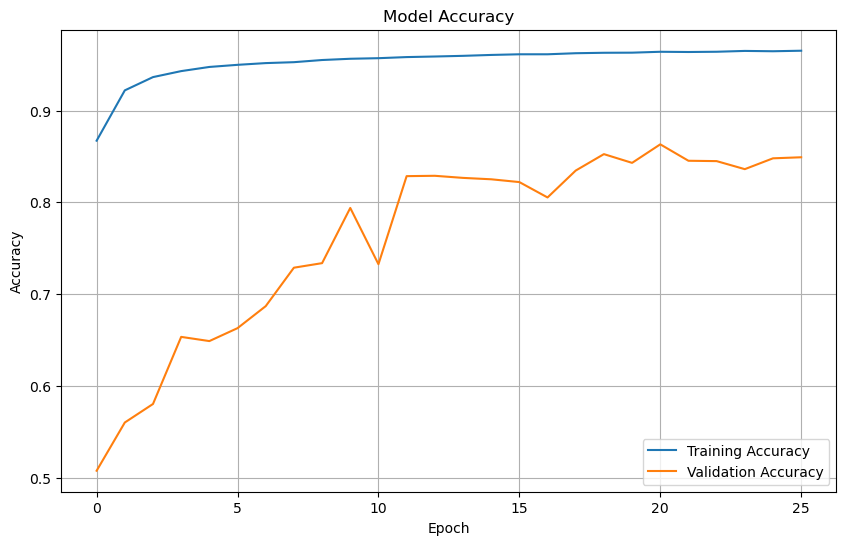


Evaluating on Validation Set...
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.31      0.99      0.47       525
         1.0       0.93      0.10      0.17       525
         2.0       0.81      0.58      0.68       525
         3.0       0.00      0.00      0.00       525
         4.0       0.89      0.87      0.88       525

    accuracy                           0.51      2625
   macro avg       0.59      0.51      0.44      2625
weighted avg       0.59      0.51      0.44      2625



/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


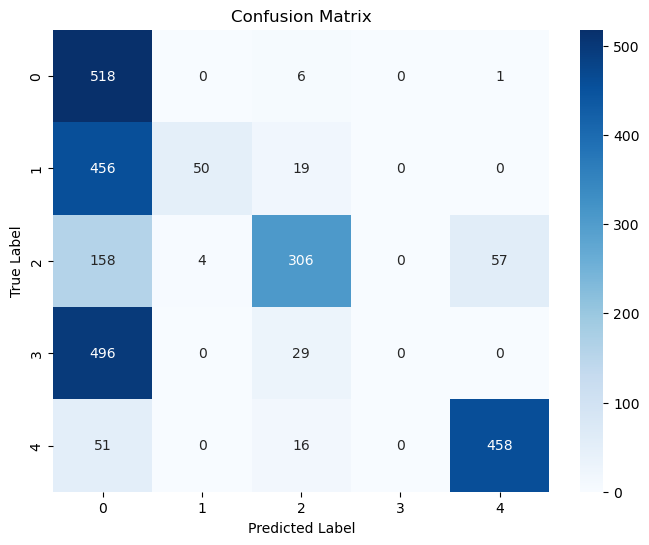

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Validation Accuracy: 0.5074

Classification Report:
              precision    recall  f1-score   support

         0.0     0.3085    0.9867    0.4701       525
         1.0     0.9259    0.0952    0.1727       525
         2.0     0.8138    0.5829    0.6792       525
         3.0     0.0000    0.0000    0.0000       525
         4.0     0.8876    0.8724    0.8799       525

    accuracy                         0.5074      2625
   macro avg     0.5872    0.5074    0.4404      2625
weighted avg     0.5872    0.5074    0.4404      2625


Confusion Matrix:
[[518   0   6   0   1]
 [456  50  19   0   0]
 [158   4 306   0  57]
 [496   0  29   0   0]
 [ 51   0  16   0 458]]


/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

# Plot the accuracy and loss curves using the built-in method
model.plot_history()

# Evaluate the model using the validation set
print("\nEvaluating on Validation Set...")
model.evaluate(X_validation, y_validation)

# Load the best model to make predictions
best_model = keras.models.load_model('saved_model.h5')

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_validation)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate and display accuracy
accuracy = accuracy_score(y_validation, y_val_pred_classes)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Generate and display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_validation, y_val_pred_classes, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_val_pred_classes))


## Accuracy on the Test set

Test set shape: (10946, 187, 1)
Test labels shape: (10946,)


343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0     0.9322    0.9912    0.9608      9012
         1.0     0.6765    0.0796    0.1424       289
         2.0     0.7958    0.5584    0.6563       754
         3.0     0.0000    0.0000    0.0000        78
         4.0     0.8988    0.8844    0.8915       813

    accuracy                         0.9223     10946
   macro avg     0.6606    0.5027    0.5302     10946
weighted avg     0.9069    0.9223    0.9062     10946

Accuracy on Test Set: 0.9223


/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


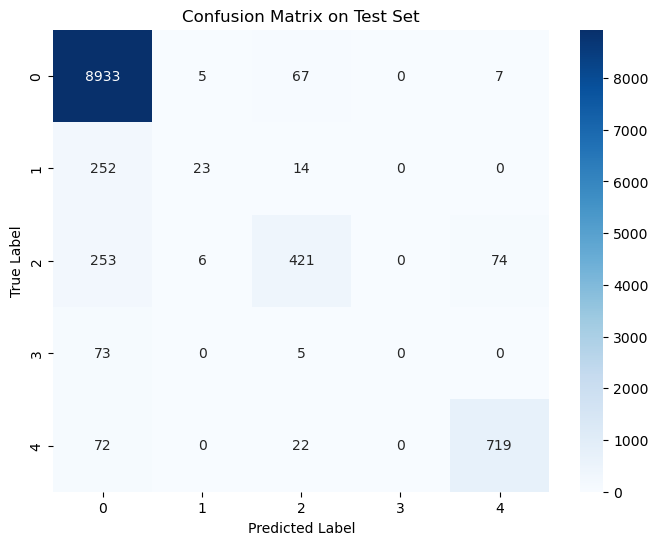

In [17]:
#%% evlauate the model with the test set

# Ensure the test data has the correct shape
X_test = np.expand_dims(X_test, axis=-1)  # Add channel dimension if not already added
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


from tensorflow import keras

# Load the best model weights
best_model = keras.models.load_model('saved_model.h5')

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Generate classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_classes, digits=4))

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig('Confusion Matrix on Test Set' , bbox_inches='tight', dpi=300)
plt.show()

## Accurracy on the Hold-out set: 

Prepared holdout set shape for augmentation: (10946, 187, 1)


Noisy holdout set shape: (10946, 187, 1)
Noisy holdout labels shape: (10946,)

Evaluating on the Noisy Holdout Set...
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Noisy Holdout Set Accuracy: 0.9298

Classification Report for Noisy Holdout Set:
              precision    recall  f1-score   support

         0.0     0.9380    0.9925    0.9645      9106
         1.0     0.7742    0.0899    0.1611       267
         2.0     0.8150    0.5965    0.6889       694
         3.0     0.0000    0.0000    0.0000        84
         4.0     0.9093    0.8830    0.8960       795

    accuracy                         0.9298     10946
   macro avg     0.6873    0.5124    0.5421     10946
weighted avg     0.9170    0.9298    0.9151     10946



/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/negin/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


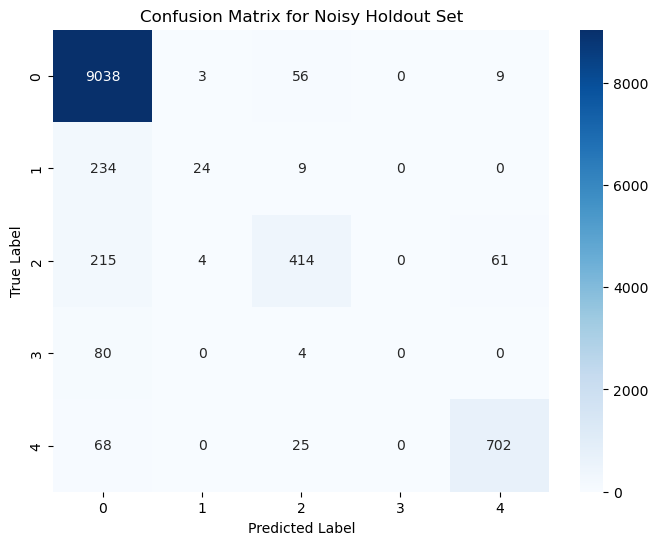

In [18]:
import numpy as np
from data_augmentation import DataAugmentation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

# Initialize the Data Augmentation class for noise injection
augmenter = DataAugmentation(
    shift_max=0,       # No time shift
    noise_level=0.1,   # Introduce significant noise
    scale_range=(1.0, 1.0), # No scaling
    expected_length=187
)

# 🆕 Prepare holdout data with the channel dimension for augmentation
X_holdout_prepared = np.expand_dims(X_holdout, axis=-1)  # Shape should be (samples, 187, 1)
y_holdout = y_holdout

#%%
print(f"Prepared holdout set shape for augmentation: {X_holdout_prepared.shape}")

# Apply noise to the holdout set with an augmentation factor of 1 (100% of samples)
X_holdout_noisy = augmenter.augment_batch(X_holdout_prepared, augmentation_factor=1.0)

# 🆕 Set the labels for the augmented noisy holdout set
num_original_samples = len(y_holdout)
num_augmented_samples = X_holdout_noisy.shape[0]

# Generate the correct number of labels for the augmented samples
y_holdout_noisy = np.repeat(y_holdout, np.ceil(num_augmented_samples / num_original_samples).astype(int))[:num_augmented_samples]

print(f"Noisy holdout set shape: {X_holdout_noisy.shape}")
print(f"Noisy holdout labels shape: {y_holdout_noisy.shape}")

# Load the best model
model = keras.models.load_model('saved_model.h5')

# Evaluate on the noisy holdout set
print("\nEvaluating on the Noisy Holdout Set...")
y_holdout_pred = model.predict(X_holdout_noisy)
y_holdout_pred_classes = np.argmax(y_holdout_pred, axis=1)

# Calculate accuracy for the noisy holdout set
holdout_accuracy = accuracy_score(y_holdout_noisy, y_holdout_pred_classes)
print(f"Noisy Holdout Set Accuracy: {holdout_accuracy:.4f}")

# Generate classification report for the noisy holdout set
print("\nClassification Report for Noisy Holdout Set:")
print(classification_report(y_holdout_noisy, y_holdout_pred_classes, digits=4))

# Generate confusion matrix for the noisy holdout set
conf_matrix_holdout = confusion_matrix(y_holdout_noisy, y_holdout_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_holdout, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Noisy Holdout Set')
plt.savefig('Confusion Matrix for Noisy Holdout Set' , bbox_inches='tight', dpi=300)
plt.show()